In [36]:
import sys
sys.path.append('../utils')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from MiguelTK import *
import warnings
warnings.filterwarnings('ignore')

## Limpieza y transformación de datos

In [37]:
df = pd.read_csv('data/ZARA_db.csv')

In [38]:
df.head()

,extracción,articulo,precio,descripcion,grupo_web,tallas,colores,enlace,marca,grupo,seccion
0,2024-05-26 23:38:27.265485,CAMISA GABARDINA CINTAS ESPALDA,22.95,Camisa confeccionada en tejido tipo gabardina....,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL', 'XXL']",[],https://www.zara.com/es/es/camisa-gabardina-ci...,ZARA,CAMISA,MUJER
1,2024-05-26 23:38:27.265485,TOP BIKINI BANDEAU PIEZA METÁLICA,19.95,Top bikini tipo bandeau con detalle de pieza m...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/top-bikini-bandeau-...,ZARA,TOP,MUJER
2,2024-05-26 23:38:27.265485,VESTIDO CAMISERO MINI GOMAS,29.95,Vestido de cuello solapa y manga sisa con frun...,V2024-MUJER-ULTIMA-SEMANA,"['XS', 'S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/vestido-camisero-mi...,ZARA,VESTIDO,MUJER
3,2024-05-26 23:38:27.265485,CHAQUETA PUNTO MANGA FRANCESA,29.95,Chaqueta de cuello redondo y manga por debajo ...,V2024-MUJER-ULTIMA-SEMANA,"['S', 'M', 'L', 'XL']",[],https://www.zara.com/es/es/chaqueta-punto-mang...,ZARA,CHAQUETA,MUJER
4,2024-05-26 23:38:27.265485,SANDALIA PLANA HEBILLAS,29.95,Sandalia plana con tiras y hebillas. Suela den...,V2024-MUJER-ULTIMA-SEMANA,"['35', '36', '37', '38', '39', '40', '41', '42']",[],https://www.zara.com/es/es/sandalia-plana-hebi...,ZARA,SANDALIA,MUJER


In [39]:
df['temporada'] = df['grupo_web'].str.extract(r'^(\w+)\-')
del df['grupo_web']

In [40]:
df['n_tallas'] = df['tallas'].str.count(r'\'(\w+)\'')

In [41]:
del df['enlace']

In [42]:
df['n_colores'] = df['colores'].str.count(r'\'(\w+)\'')

In [43]:
df['contiene_lino'] = df['descripcion'].str.contains(r'lino',case=False)

In [44]:
df['contiene_algodon'] = df['descripcion'].str.contains(r'algodón',case=False)

In [45]:
df['tipo_talla'] = (
    df['tallas']
    .str.contains(r'\d')
    .map({
        True:'numérica',
        False:'alfabética'
    })
)

In [46]:
df['colores'] = df['colores'].str.upper()

## Estudio de colores

In [47]:
tabla_colores = (
    df['colores']
    .str.replace(r'[\[\]\']','',regex=True)
    .str.replace(r'\,\s',',',regex=True)
    .str.split(',',expand=True)
    .assign(seccion = df['seccion'])
    .melt('seccion')
    .drop(columns='variable')
    .dropna(subset='value')
    .query('value != ""')
)
tabla_colores

,seccion,value
9,MUJER,BLANCO
14,MUJER,BLANCO
18,MUJER,ROJO BURDEOS
45,MUJER,BLANCO
48,MUJER,GRIS ANTRACITA
...,...,...
8430,HOMBRE,MARRÓN
8451,HOMBRE,AZUL / BLANCO
9022,MUJER,MULTICOLOR
9207,HOMBRE,AZUL


In [48]:
B_N = (
    tabla_colores
    ['value']
    .str.contains(r'(NEGRO)|(BLANCO)',regex=True)
)

Colores más frecuentes por sección (diferentes al blanco y negro)


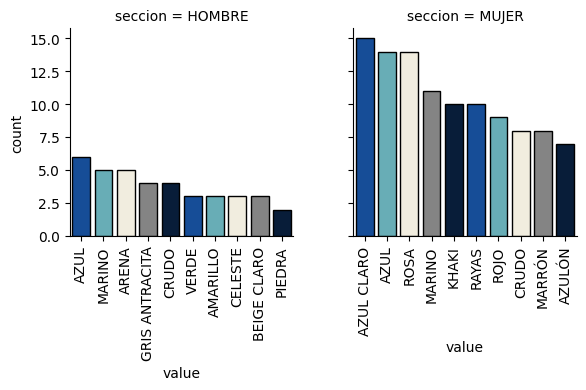

In [49]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nlargest(10,'count'))
)
grid = sns.FacetGrid(df_,col='seccion',sharex=False)
grid.map(sns.barplot,'value','count',**kwargs)
grid.tick_params('x',rotation=90)
print('Colores más frecuentes por sección (diferentes al blanco y negro)')

In [50]:
df_ = (
    tabla_colores[~B_N]
    .groupby('seccion',as_index=False)
    ['value']
    .value_counts()
    .groupby('seccion')
    .apply(lambda x: x.nsmallest(10,'count'))
    .drop(columns='seccion')
    .reset_index()
    .drop(columns=['level_1','count'])
)
print('Colores menos frecuentes por sección (diferentes al blanco y negro)')
print(df_)

Colores menos frecuentes por sección (diferentes al blanco y negro)
   seccion           value
0   HOMBRE    CRUDO / AZUL
1   HOMBRE    CORAL FUERTE
2   HOMBRE  ROSA EMPOLVADO
3   HOMBRE   CELESTE CLARO
4   HOMBRE     AZUL / GRIS
5   HOMBRE     AZUL OSCURO
6   HOMBRE          AZULÓN
7   HOMBRE           BEIGE
8   HOMBRE   BEIGE PLATINO
9   HOMBRE          CARBÓN
10   MUJER      MULTICOLOR
11   MUJER         NARANJA
12   MUJER   MARRÓN OSCURO
13   MUJER  NARANJA OSCURO
14   MUJER          MORADO
15   MUJER          MEDIUM
16   MUJER     MARSHMALLOW
17   MUJER        PETRÓLEO
18   MUJER       MANDARINA
19   MUJER       LIME FIZZ


<Axes: xlabel='seccion', ylabel='n_colores'>

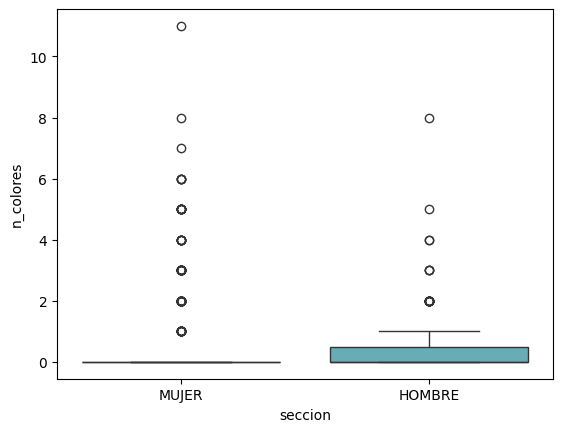

In [51]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_colores',
    palette = palette
)

La ropa masculina tiene mayor variedad en los colores disponibles.

## Estudio de composición

In [52]:
df['contiene_lino'].value_counts(normalize=True)

contiene_lino
False    0.885457
True     0.114543
Name: proportion, dtype: float64

El `11 %` de las prendas de ropa contienen lino

In [53]:
df['contiene_algodon'].value_counts(normalize=True)

contiene_algodon
False    0.875161
True     0.124839
Name: proportion, dtype: float64

El `15 %` de las prendas de ropa contienen algodón

In [54]:
pd.crosstab(
    df['contiene_lino'],
    df['seccion'],
    normalize='index'
)

seccion,HOMBRE,MUJER
contiene_lino,,
False,0.186047,0.813953
True,0.213483,0.786517


In [55]:
pd.crosstab(
    df['contiene_algodon'],
    df['seccion'],
    normalize='index'
)

seccion,HOMBRE,MUJER
contiene_algodon,,
False,0.152941,0.847059
True,0.443299,0.556701


Las prendas de ropa que contienen o bien lino o bien algodón tienen más posibilidades de ser de la sección masculina.

<Axes: xlabel='contiene_lino', ylabel='precio'>

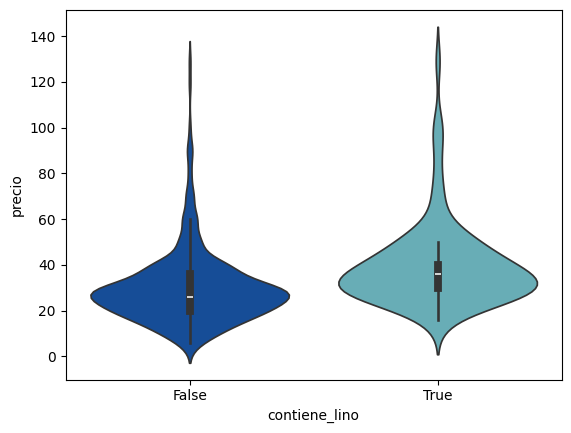

In [56]:
sns.violinplot(
    data = df,
    x = 'contiene_lino',
    y = 'precio',
    palette = palette
)

Las prendas que contienen `lino` pueden tener precios más altos que las que no lo contienen.

## Estudio de tallas

### Tallas extremas

#### Tallas letras

In [57]:
df_ = df.query('tipo_talla == "alfabética"')

In [58]:
pd.crosstab(
    df_['tallas'].str.contains('XS'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER
tallas,,
False,0.358974,0.641026
True,0.000000,1.000000


In [59]:
pd.crosstab(
    df_['tallas'].str.contains('XL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER
tallas,,
False,0.055300,0.944700
True,0.215517,0.784483


In [60]:
pd.crosstab(
    df_['tallas'].str.contains('XXL'),
    df_['seccion'],
    normalize = 'index'
)

seccion,HOMBRE,MUJER
tallas,,
False,0.191972,0.808028
True,0.018519,0.981481


- Las prendas que tienen la talla `XS` disponible pertenecen casi todas a la sección femenina. 
- Las prendas con las talla `XL` disponible están en mayor equilibrio.
- Las prendas que tienen disponible la talla `XXL` pertenecen en mayor proporción a la sección femenina, y las que no tienen esa talla disponible son en su mayoría de caballero.

### Número de tallas disponibles

<Axes: xlabel='seccion', ylabel='n_tallas'>

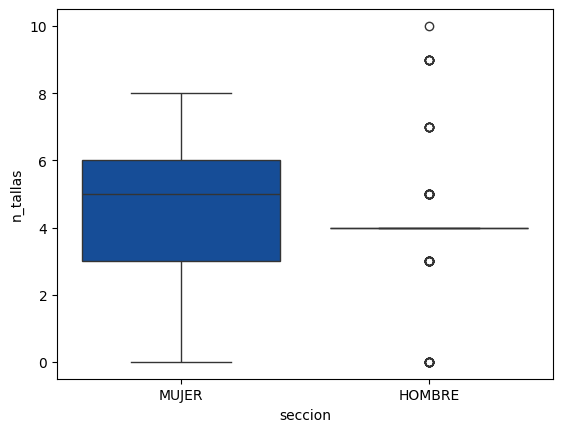

In [61]:
sns.boxplot(
    data = df,
    x = 'seccion',
    y = 'n_tallas',
    palette = palette
)

La ropa de la sección de mujer ofrece una mayor variedad de tallas.

## Palabras clave
porcentaje de prendas cuya descripción contiene la palabra clave:

In [62]:
# RELAXED
df['descripcion'].str.contains('relaxed',case=False).sum() / len(df)

0.07722007722007722

In [63]:
# FIT
df['descripcion'].str.contains('fit',case=False).sum() / len(df)

0.17503217503217502

In [64]:
# BRILLOS
df['descripcion'].str.contains(r'brillos?',case=False).sum() / len(df)

0.018018018018018018

In [65]:
# ESTAMPADO ANIMAL
df['descripcion'].str.contains(r'estampado\sanimal',case=False,regex=True).sum() / len(df)

0.001287001287001287

In [66]:
# ASIMÉTRICO
df['descripcion'].str.contains(r'asimétric[oa]',case=False).sum() / len(df)

0.04633204633204633

In [67]:
# OVERSIZE
df['descripcion'].str.contains(r'over\s?size',case=False).sum() / len(df)

0.007722007722007722

In [68]:
# EFECTO ARRUGADO
df['descripcion'].str.contains(r'efecto arrugado',case=False).sum() / len(df)

0.007722007722007722